## General    
This notebook uses the pretrained models from the notebook "pretrain_each_timestep".    
In this notebook I feed the 5 timesteps into the corresponding pretrained models to get 5 output masks. Those output 
masks are passed as 5 channel input into another Unet which creates the final mask.   



Results preview:
Dice score improved from 0.602 to 0.610, so not much of an improvment

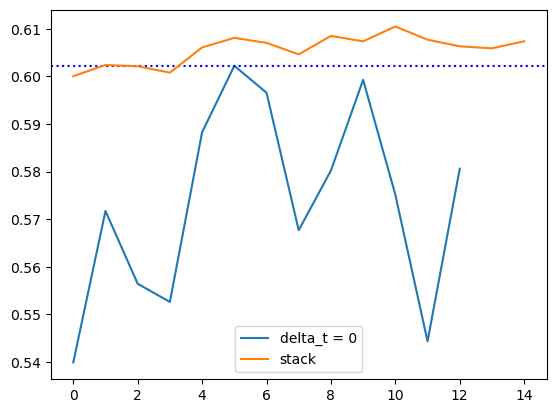

In [39]:
delta = 0
label = 'delta_t = '+str(delta)
metrics = pd.read_csv("./pretrained_timesteps_resnest101_contrail_only_ashcolour/model_at_timestep_mask_plus_delta_"+str(delta)+"/version_0/metrics.csv")
metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
plt.plot(metrics['val_dice'], label=label)

plt.axhline(y = metrics['val_dice'].max(), color = 'b', linestyle = ':')

metrics = pd.read_csv("./pretrained_timesteps_resnest101_contrail_only_ashcolour/stack_of_all_timesteps/version_10/metrics.csv")
metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
plt.plot(metrics['val_dice'], label="stack")
    
plt.legend()
plt.show()

## Code

### Setup

#### Imports

In [3]:
import deepdish
import glob
import h5py
import lightning as L
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
import numpy as np
import os
import pandas as pd
import segmentation_models_pytorch as smp
import torchvision.transforms as T
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
from torchmetrics.functional import dice
from torch.utils.data import Dataset, DataLoader
import warnings
import yaml

warnings.filterwarnings("ignore")



#### Specify the data source

In [4]:
data_path_mf_contrail_only_train = "/home/albert/ml/Contrails/data/contrail dataset from hungrylearner/train/"
data_path_mf_all_valid = "/home/albert/ml/Contrails/data/validation contrail/"

#### Create, write and load the config files

In [5]:
%%writefile config_resnest101_Unet_pretrained.yaml

model:
    seg_model: "Unet"
    encoder_name: "timm-resnest101e"
    loss_smooth: 1.0
    image_size: 384

Overwriting config_resnest101_Unet_pretrained.yaml


In [6]:
%%writefile config_top_model.yaml

model:
    seg_model: "Unet"
    encoder_name: "timm-resnest101e"
    loss_smooth: 1.0
    image_size: 384

Overwriting config_top_model.yaml


In [7]:
%%writefile config_stack_model.yaml

model:
    loss_smooth: 1.0
    image_size: 384
    optimizer_params:
        lr: 0.0005
        weight_decay: 0.0
    scheduler:
        name: "CosineAnnealingLR"
        params:
            CosineAnnealingLR:
                T_max: 2
                eta_min: 1.0e-6
                last_epoch: -1
            ReduceLROnPlateau:
                mode: "min"
                factor: 0.31622776601
                patience: 4
                verbose: True

Overwriting config_stack_model.yaml


In [8]:
%%writefile config_training.yaml

output_dir: "./pretrained_timesteps_resnest101_contrail_only_ashcolour"

seed: 42

train_bs: 48
valid_bs: 128
workers: 6

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 5
    verbose: 1

trainer:
    max_epochs: 26
    min_epochs: 19
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 1



Overwriting config_training.yaml


In [9]:
with open("config_resnest101_Unet_stack.yaml", "r") as file_obj:
    config_resnest101_Unet_stack = yaml.safe_load(file_obj)
    
with open("config_top_model.yaml", "r") as file_obj:
    config_top_model = yaml.safe_load(file_obj)  

with open("config_stack_model.yaml", "r") as file_obj:
    config_stack_model = yaml.safe_load(file_obj)  
    
with open("config_training.yaml", "r") as file_obj:
    config_training = yaml.safe_load(file_obj)

In [10]:
!mkdir ./pretrained_timesteps_resnest101_contrail_only_ashcolour

mkdir: cannot create directory ‘./pretrained_timesteps_resnest101_contrail_only_ashcolour’: File exists


### Create Dataset     
The dataset loads the contrail-only dataset from *hungrylearner* for training and the full validation dataset from the original competition data.

In [11]:
class ContrailsDatasetMixed(Dataset):
    def __init__(self, split="train", mode="single", delta_t = 0):
        self.delta_t = delta_t
        self.split = split
        self.mode = mode
        self.path = (lambda x: data_path_mf_contrail_only_train if x == "train" else data_path_mf_all_valid)(self.split)
        self.examples = os.listdir(self.path)
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
    def read_record(self, directory):
        record_data = {}
        for x in [
            "band_11", 
            "band_14", 
            "band_15"
        ]:
            record_data[x] = np.load(os.path.join(directory, x + ".npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def get_false_color(self, record_data):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        if self.split == "train":
            r = self.normalize_range(record_data[7] - record_data[6], _TDIFF_BOUNDS)
            g = self.normalize_range(record_data[6] - record_data[3], _CLOUD_TOP_TDIFF_BOUNDS)
            b = self.normalize_range(record_data[6], _T11_BOUNDS)
        else:
            r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
            g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
            b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        if self.mode == "single":
            t_null = 4
            return false_color[..., t_null+self.delta_t]
        else:
            return false_color
    
    def __getitem__(self, index):
        if self.split == "train":
            sample_path = f"{self.path}{self.examples[index]}"
            data = deepdish.io.load(sample_path)  # dict (bands, masks)
            img = self.get_false_color(data["bands"]) 
            label = data["masks"][..., -1] 
            label = torch.Tensor(label).to(torch.int64)
            
        if self.split == "validation":
            path = f"{self.path}{self.examples[index]}"
            data = self.read_record(path)    
            img = self.get_false_color(data)
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)

        if self.mode == "single":
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1).squeeze()
        else:
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1)

        img = self.normalize_image(img)

        if self.split in ["train", "validation"]:
            return img.float(), label.float()

        return img.float()
    
    def __len__(self):
        return len(self.examples)

### Create Lightning Modules      
#### for the pretrained models, the model on top and the complete Stack

In [12]:
seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}

In [13]:
class LightningModule_pretrained(L.LightningModule):
    def __init__(self):
        super().__init__()
        config = config_resnest101_Unet_stack["model"] #passing config as parameter produces error when loading checkpoints, even from already initialized model
        self.config = config
        self.model = model = seg_models[config["seg_model"]](
            encoder_name=config["encoder_name"],
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        )
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

In [14]:
class LightningModule_top(L.LightningModule):
    def __init__(self):
        super().__init__()
        config = config_top_model["model"] #passing config as parameter produces error when loading checkpoints, even from already initialized model
        self.config = config
        self.model = model = seg_models[config["seg_model"]](
            encoder_name=config["encoder_name"],
            encoder_weights="imagenet",
            in_channels=5,
            classes=1,
            activation=None,
        )
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

## Ensemble

In [15]:
class MyStack(L.LightningModule):
    def __init__(self, model_minus_one, model_null,model_plus_one,model_plus_two,model_plus_three, model_top):
        super(MyStack, self).__init__()
        config = config_stack_model["model"]
        self.config = config
        self.model_minus_one = model_minus_one
        self.model_null = model_null
        self.model_plus_one = model_plus_one
        self.model_plus_two = model_plus_two
        self.model_plus_three = model_plus_three
        self.model_top = model_top
        
        self.model_minus_one.freeze()
        self.model_null.freeze()
        self.model_plus_one.freeze()
        self.model_plus_two.freeze()
        self.model_plus_three.freeze()
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=1.0)
        # self.save_hyperparameters(ignore=['model_minus_one','model_null'])
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, x):
        x_permuted = x.permute(1, 0, 2, 3, 4)
        minus_one = self.model_minus_one(x_permuted[3].squeeze())
        null = self.model_null(x_permuted[4].squeeze())
        plus_one = self.model_plus_one(x_permuted[5].squeeze())
        plus_two = self.model_plus_two(x_permuted[6].squeeze())
        plus_three = self.model_plus_three(x_permuted[7].squeeze())
        all_output_masks = [minus_one,null,plus_one,plus_two,plus_three]
        stacked_masks = torch.stack(all_output_masks, dim = 1) #dim 0 is batch
        x = self.model_top(stacked_masks.squeeze())
        # print(torch.unique(x))
        return x
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.forward(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.forward(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

In [16]:
def train_stack(model_top, stack_model):
    identifier = "stack_of_all_timesteps"
    
    dataset_train = ContrailsDatasetMixed("train", "multi")
    dataset_validation = ContrailsDatasetMixed("validation","multi")
    
    data_loader_train = DataLoader(
    dataset_train,
    batch_size=config_training["train_bs"],
    shuffle=True,
    num_workers=config_training["workers"],
    )
    
    data_loader_validation = DataLoader(
        dataset_validation,
        batch_size=config_training["valid_bs"],
        shuffle=False,
        num_workers=config_training["workers"],
    )
    
    checkpoint_callback = ModelCheckpoint(
    save_weights_only=True,
    monitor="val_dice",
    dirpath=config_training["output_dir"],
    mode="max",
    filename= identifier,
    save_top_k=1,
    verbose=1,
    )
    progress_bar_callback = TQDMProgressBar(
    refresh_rate=config_training["progress_bar_refresh_rate"]
    )

    early_stop_callback = EarlyStopping(**config_training["early_stop"])
    csv_logger = CSVLogger(config_training["output_dir"], name=identifier)
    trainer = L.Trainer(
        callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback], logger = csv_logger,
        **config_training["trainer"],
    )
    
    config_stack_model["model"]["scheduler"]["params"]["CosineAnnealingLR"]["T_max"] *= len(data_loader_train)/config_resnest101_Unet_stack["trainer"]["devices"]
    model_minus_one = LightningModule_pretrained().load_from_checkpoint(config_resnest101_Unet_stack["output_dir"]+"/model_at_timestep_mask_plus_delta_"+"-1"+".ckpt")
    model_null = LightningModule_pretrained().load_from_checkpoint(config_resnest101_Unet_stack["output_dir"]+"/model_at_timestep_mask_plus_delta_"+"0"+".ckpt")
    model_plus_one = LightningModule_pretrained().load_from_checkpoint(config_resnest101_Unet_stack["output_dir"]+"/model_at_timestep_mask_plus_delta_"+"1"+".ckpt")
    model_plus_two = LightningModule_pretrained().load_from_checkpoint(config_resnest101_Unet_stack["output_dir"]+"/model_at_timestep_mask_plus_delta_"+"2"+".ckpt")
    model_plus_three = LightningModule_pretrained().load_from_checkpoint(config_resnest101_Unet_stack["output_dir"]+"/model_at_timestep_mask_plus_delta_"+"3"+".ckpt")
    model_top = LightningModule_top()

    model =  MyStack(model_minus_one,model_null,model_plus_one,model_plus_two,model_plus_three,model_top)
    
    trainer.fit(model, data_loader_train, data_loader_validation)
    
    

In [134]:
train_stack()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                       | Params
----------------------------------------------------------------
0 | model_minus_one  | LightningModule_pretrained | 55.3 M
1 | model_null       | LightningModule_pretrained | 55.3 M
2 | model_plus_one   | LightningModule_pretrained | 55.3 M
3 | model_plus_two   | LightningModule_pretrained | 55.3 M
4 | model_plus_three | LightningModule_pretrained | 55.3 M
5 | model_top        | LightningModule_top        | 55.3 M
6 | loss_module      | DiceLoss                   | 0     
----------------------------------------------------------------
55.3 M    Trainable params
276 M     Non-trainable params
331 M     Total params
1,326.185 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Metric val_loss improved. New best score: 0.640
Epoch 0, global step 193: 'val_dice' reached 0.60006 (best 0.60006), saving model to '/home/albert/ml/Contrails/notebooks/working_with_hdf_dataset/train_single_on_other_timesteps/pretrained_timesteps_resnest101_contrail_only_ashcolour/stack_of_all_timesteps.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 1


Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 0.534
Epoch 1, global step 386: 'val_dice' reached 0.60241 (best 0.60241), saving model to '/home/albert/ml/Contrails/notebooks/working_with_hdf_dataset/train_single_on_other_timesteps/pretrained_timesteps_resnest101_contrail_only_ashcolour/stack_of_all_timesteps.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.484
Epoch 2, global step 579: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 3


Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.430
Epoch 3, global step 772: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 4


Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.415
Epoch 4, global step 965: 'val_dice' reached 0.60609 (best 0.60609), saving model to '/home/albert/ml/Contrails/notebooks/working_with_hdf_dataset/train_single_on_other_timesteps/pretrained_timesteps_resnest101_contrail_only_ashcolour/stack_of_all_timesteps.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 5


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.410
Epoch 5, global step 1158: 'val_dice' reached 0.60811 (best 0.60811), saving model to '/home/albert/ml/Contrails/notebooks/working_with_hdf_dataset/train_single_on_other_timesteps/pretrained_timesteps_resnest101_contrail_only_ashcolour/stack_of_all_timesteps.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 6


Epoch 6, global step 1351: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 7


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.408
Epoch 7, global step 1544: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 8


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.402
Epoch 8, global step 1737: 'val_dice' reached 0.60852 (best 0.60852), saving model to '/home/albert/ml/Contrails/notebooks/working_with_hdf_dataset/train_single_on_other_timesteps/pretrained_timesteps_resnest101_contrail_only_ashcolour/stack_of_all_timesteps.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 9


Epoch 9, global step 1930: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 10


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.399
Epoch 10, global step 2123: 'val_dice' reached 0.61050 (best 0.61050), saving model to '/home/albert/ml/Contrails/notebooks/working_with_hdf_dataset/train_single_on_other_timesteps/pretrained_timesteps_resnest101_contrail_only_ashcolour/stack_of_all_timesteps.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 11


Epoch 11, global step 2316: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 12


Epoch 12, global step 2509: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 13


Epoch 13, global step 2702: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 14


Monitored metric val_loss = nan is not finite. Previous best value was 0.399. Signaling Trainer to stop.
Epoch 14, global step 2895: 'val_dice' was not in top 1


### Results

t_0 only dice_val  0.6022409200668335
stack dice_val     0.6105044484138489


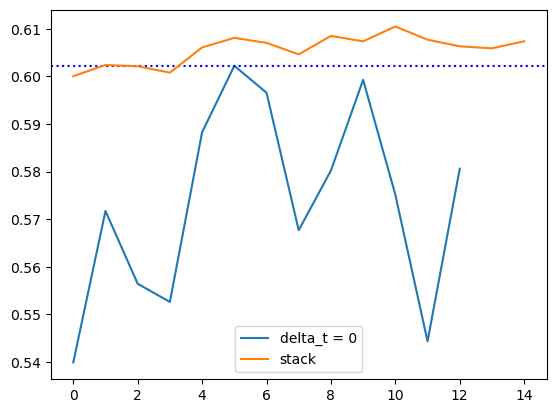

In [53]:
delta = 0
label = 'delta_t = '+str(delta)
metrics = pd.read_csv("./pretrained_timesteps_resnest101_contrail_only_ashcolour/model_at_timestep_mask_plus_delta_"+str(delta)+"/version_0/metrics.csv")
metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
plt.plot(metrics['val_dice'], label=label)

plt.axhline(y = metrics['val_dice'].max(), color = 'b', linestyle = ':')
print("t_0 only dice_val ",metrics['val_dice'].max())

metrics = pd.read_csv("./pretrained_timesteps_resnest101_contrail_only_ashcolour/stack_of_all_timesteps/version_10/metrics.csv")
metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
plt.plot(metrics['val_dice'], label="stack")

print("stack dice_val    ",metrics['val_dice'].max())
plt.legend()
plt.show()